# Pilot Analyses -- Psifr Edition

## Setup

In [1]:
#%% Dependencies

from experiments.cat_target_short.helpers import export_to_psifr_long_table, load_data
from psifr import fr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def export_to_psifr_long_table(data: dict[str, np.ndarray]) -> pd.DataFrame:
    """Convert data in EMBAM format to long table psifr format.

    Args:
        data (dict[str, np.ndarray]): Data in EMBAM format. In EMBAM format, data is stored
        in a dictionary where each key corresponds to a different variable. The values are
        2-D numpy arrays where each row corresponds to a trial. Required fields in the EMBAM
        format are: 'subject', 'listLength', 'pres_itemnos', 'recalls'. Additional fields
        such as 'condition', 'pres_itemids', and 'rec_itemids' can identify details about
        the trial or each presented or recalled item.

    Returns:
        pd.DataFrame: A pandas DataFrame whose rows correspond to a single study or recall
        event. The required fields in each row are 'subject', 'list', 'trial_type', 'position',
        and 'item'. Additional fields can be included to describe events, e.g., 'condition'.
    """
    events = {
        "subject": [],
        "list": [],
        "trial_type": [],
        "position": [],
        "item": [],
        "condition": [],
        "target_success": [],
        "listLength": [],
        "trial_category_cue": [],
        "category": [],
    }

    # first all study events
    for trial_index, trial in enumerate(data["pres_itemids"]):
        for study_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("study")
            events["position"].append(study_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["pres_categoryids"][trial_index, study_index]
            )

    # then all recall events
    for trial_index, trial in enumerate(data["rec_itemids"]):
        for recall_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("recall")
            events["position"].append(recall_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["rec_categoryids"][trial_index, recall_index]
            )

    return pd.DataFrame.from_dict(events)

In [3]:
# %% Load data
embam_data_path = "experiments/cat_target_short/expt_milind.h5"
embam_data = load_data(embam_data_path)
events = export_to_psifr_long_table(embam_data)
events.head()

,subject,list,trial_type,position,item,condition,target_success,listLength,trial_category_cue,category
0,0,1,study,1,44,0,False,6,0,3
1,0,1,study,2,313,0,False,6,0,18
2,0,1,study,3,145,0,False,6,0,9
3,0,1,study,4,337,0,False,6,0,20
4,0,1,study,5,85,0,False,6,0,5


In [4]:
# %% Merge study and recall events
data = fr.merge_free_recall(
    events,
    list_keys=['condition', 'target_success', 'listLength', 'trial_category_cue', 'category']
)
data.head()


,subject,list,item,input,output,study,recall,repeat,intrusion,condition,target_success,listLength,trial_category_cue,category,prior_list,prior_input
0,0,1,44,1,1.0,True,True,0,False,0,False,6,0,3,NaN,NaN
1,0,1,313,2,NaN,True,False,0,False,0,False,6,0,18,NaN,NaN
2,0,1,145,3,2.0,True,True,0,False,0,False,6,0,9,NaN,NaN
3,0,1,337,4,NaN,True,False,0,False,0,False,6,0,20,NaN,NaN
4,0,1,85,5,3.0,True,True,0,False,0,False,6,0,5,NaN,NaN


## Demo Analyses

Pretty colors.

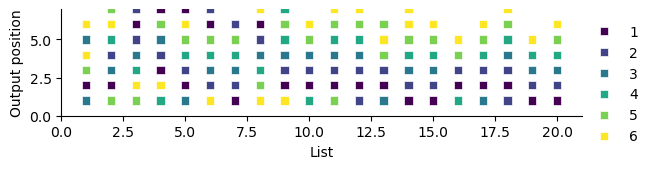

In [5]:
# %% Raster Plot
subj = fr.filter_data(data, 1)
g = fr.plot_raster(subj).add_legend()

Successfully reduced primacy effect in PFR? Yeah. For now.

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.250,2,8,control
1,0,1,2,0.125,1,8,control
2,0,1,3,0.000,0,8,control
3,0,1,4,0.000,0,8,control
4,0,1,5,0.000,0,8,control
...,...,...,...,...,...,...,...
67,1,6,2,NaN,0,0,failure
68,1,6,3,NaN,0,0,failure
69,1,6,4,NaN,0,0,failure
70,1,6,5,NaN,0,0,failure


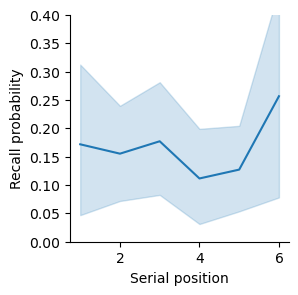

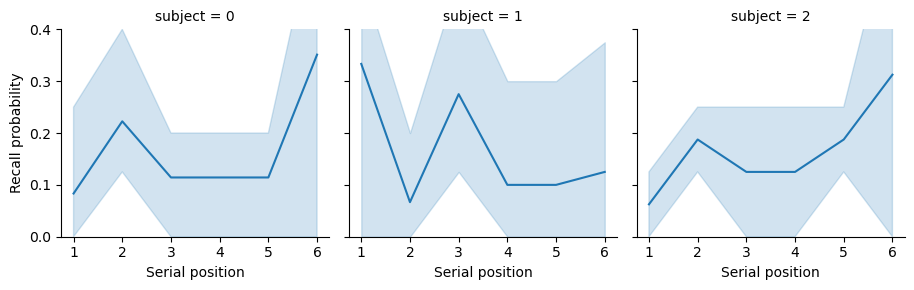

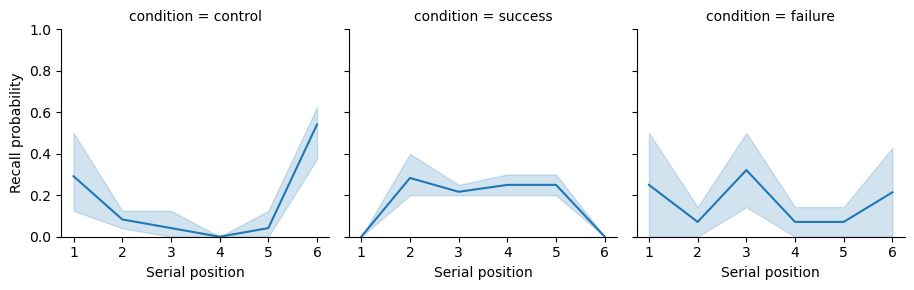

In [6]:
# %% PFR

pnr_control = fr.pnr(data.query('condition == 0'))
pnr_success = fr.pnr(data.query('condition == 2'))
pnr_attempt = fr.pnr(data.query('condition == 1'))
pnr = pd.concat([pnr_control.assign(condition='control'), pnr_success.assign(condition='success'), pnr_attempt.assign(condition='failure')])

pfr = pnr.query('output <= 1')
g = fr.plot_spc(pfr)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)
pnr

Look at what's recalled after the category-cued item.

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.250,2,8,control
1,0,1,2,0.125,1,8,control
2,0,1,3,0.000,0,8,control
3,0,1,4,0.000,0,8,control
4,0,1,5,0.000,0,8,control
...,...,...,...,...,...,...,...
67,1,6,2,NaN,0,0,failure
68,1,6,3,NaN,0,0,failure
69,1,6,4,NaN,0,0,failure
70,1,6,5,NaN,0,0,failure


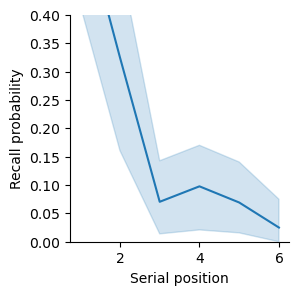

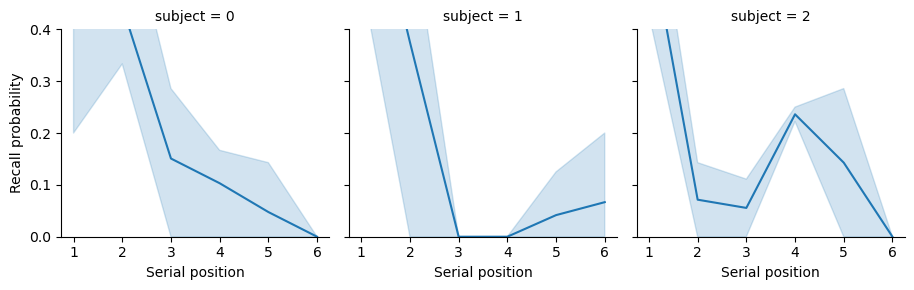

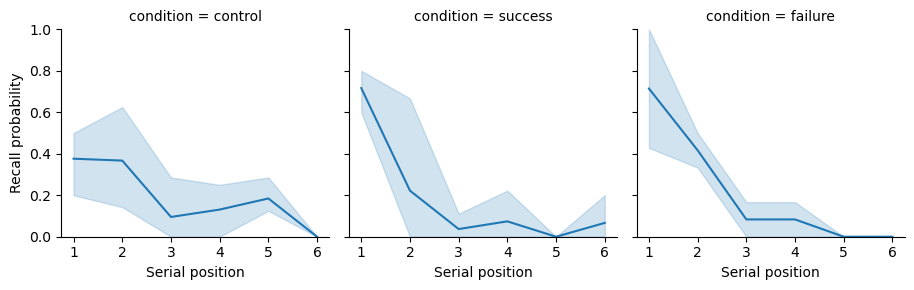

In [7]:
# %% P2R

pnr_control = fr.pnr(data.query('condition == 0'))
pnr_success = fr.pnr(data.query('condition == 2'))
pnr_attempt = fr.pnr(data.query('condition == 1'))
pnr = pd.concat([pnr_control.assign(condition='control'), pnr_success.assign(condition='success'), pnr_attempt.assign(condition='failure')])

pfr = pnr.query('output == 2')
g = fr.plot_spc(pfr)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)
pnr

Is lag-contiguity disrupted by our category cueing?

,subject,lag,prob,actual,possible,condition
0,0,-5,0.250000,1,4,control
1,0,-4,0.400000,2,5,control
2,0,-3,0.000000,0,7,control
3,0,-2,0.125000,1,8,control
4,0,-1,0.461538,6,13,control
...,...,...,...,...,...,...
17,1,1,0.714286,5,7,failure
18,1,2,0.000000,0,5,failure
19,1,3,0.000000,0,5,failure
20,1,4,0.333333,1,3,failure


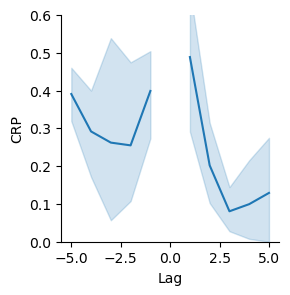

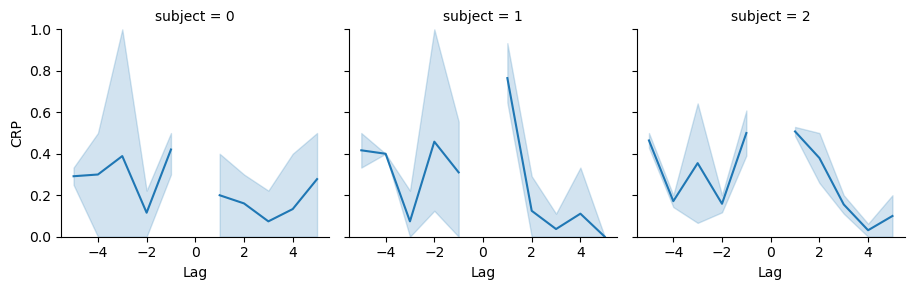

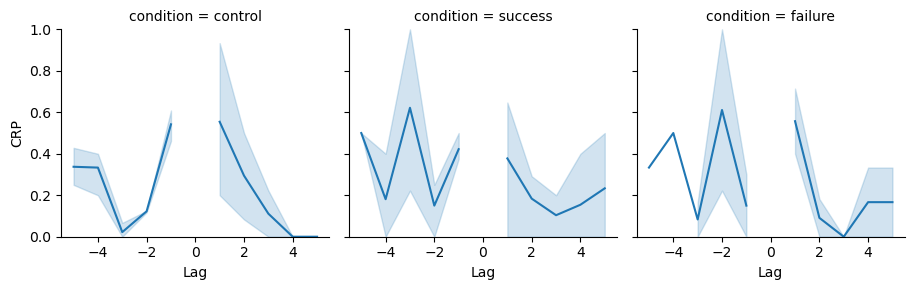

In [8]:
# %% Lag-CRP

crp_control = fr.lag_crp(data.query('condition == 0'))
crp_success = fr.lag_crp(data.query('condition == 2'))
crp_attempt = fr.lag_crp(data.query('condition == 1'))
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# lag_crp = fr.lag_crp(data)
g = fr.plot_lag_crp(lag_crp)
plt.ylim([0, .6])
g = fr.plot_lag_crp(lag_crp, col='subject', col_wrap=5)
#plt.ylim([0, .6])
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [9]:
# %% Lag-Rank Analysis
ranks_control = fr.lag_rank(data.query('condition == 0'))
ranks_success = fr.lag_rank(data.query('condition == 2'))
ranks_attempt = fr.lag_rank(data.query('condition == 1'))
ranks = pd.concat([ranks_control.assign(condition='control'), ranks_success.assign(condition='success'), ranks_attempt.assign(condition='failure')])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])
ranks

control
mean    0.717984
sem     0.085959
Name: rank, dtype: float64
success
mean    0.594362
sem     0.103351
Name: rank, dtype: float64
failure
mean    0.665923
sem     0.113839
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.620098,control
1,1,0.889323,control
2,2,0.644531,control
0,0,0.401042,success
1,1,0.754386,success
2,2,0.627660,success
0,0,0.552083,failure
1,1,0.779762,failure


## How Often Do Subjects Recall the Category Target?

In [10]:
# %% Focus on targetting trials, then aggregating target_success by subject
success_rates = data.query('condition > 0').pivot_table(
    index='subject', values='target_success', aggfunc='mean')

# mean and sem over subjects
print(success_rates.agg(['mean', 'sem'])['target_success'])
success_rates

mean    0.748167
sem     0.172152
Name: target_success, dtype: float64


,target_success
subject,
0,0.418919
1,0.825581
2,1.000000


## Focusing on Transitions From Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-5,0.333333,1,3,control
1,0,-4,0.666667,2,3,control
2,0,-3,0.000000,0,3,control
3,0,-2,0.000000,0,1,control
4,0,-1,0.250000,1,4,control
...,...,...,...,...,...,...
17,1,1,0.500000,1,2,failure
18,1,2,NaN,0,0,failure
19,1,3,NaN,0,0,failure
20,1,4,NaN,0,0,failure


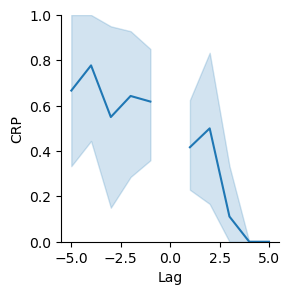

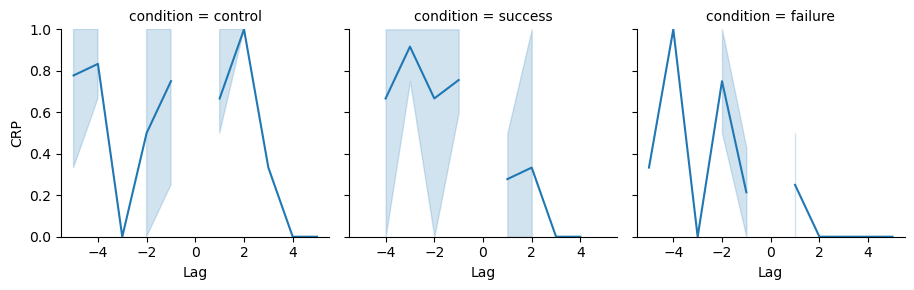

In [11]:
# %% First Transition Lag-CRP
crp_control = fr.lag_crp(data.query('condition == 0'), item_query='output < 3 or not recall')
crp_success = fr.lag_crp(data.query('condition == 2'), item_query='output < 3 or not recall')
crp_attempt = fr.lag_crp(data.query('condition == 1'), item_query='output < 3 or not recall')
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

,subject,lag,prob,actual,possible,condition
0,0,-5,NaN,0,0,control
1,0,-4,NaN,0,0,control
2,0,-3,0.0,0,1,control
3,0,-2,NaN,0,0,control
4,0,-1,1.0,1,1,control
...,...,...,...,...,...,...
17,1,1,NaN,0,0,failure
18,1,2,NaN,0,0,failure
19,1,3,NaN,0,0,failure
20,1,4,NaN,0,0,failure


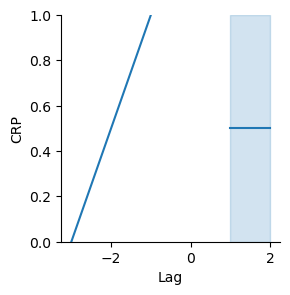

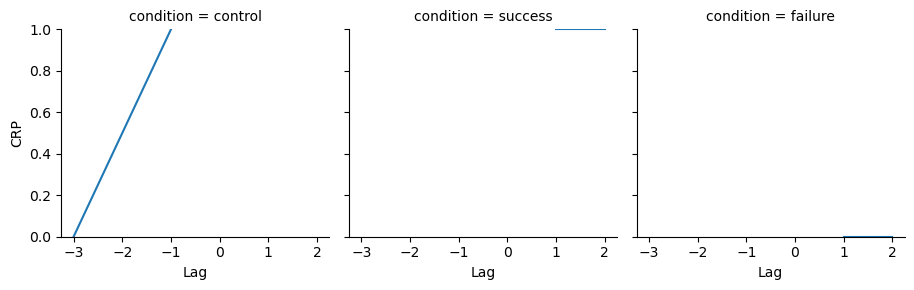

In [12]:
#! code-summary: added query to exclude transitiosn to first item in the list in our condition==2

crp_control = fr.lag_crp(data.query('condition == 0'),  item_query='(output < 3 or not recall) and input > 2')
crp_success = fr.lag_crp(data.query('condition == 2'),  item_query='(output < 3 or not recall) and input > 2')
crp_attempt = fr.lag_crp(data.query('condition == 1'),  item_query='(output < 3 or not recall) and input > 2')
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [13]:
# %% First Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), item_query='output < 3 or not recall')
ranks_success = fr.lag_rank(data.query('condition == 2'), item_query='output < 3 or not recall')
ranks_attempt = fr.lag_rank(data.query('condition == 1'), item_query='output < 3 or not recall')

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.523810
sem     0.289655
Name: rank, dtype: float64
success
mean    0.266667
sem     0.158990
Name: rank, dtype: float64
failure
mean    0.491071
sem     0.008929
Name: rank, dtype: float64


,subject,rank
0,0,0.55
1,1,0.00
2,2,0.25


## Modification: Ignore Transitions to First Item from Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-5,NaN,0,0,control
1,0,-4,1.0,2,2,control
2,0,-3,0.0,0,2,control
3,0,-2,0.0,0,1,control
4,0,-1,0.5,1,2,control
...,...,...,...,...,...,...
17,1,1,1.0,1,1,failure
18,1,2,NaN,0,0,failure
19,1,3,NaN,0,0,failure
20,1,4,NaN,0,0,failure


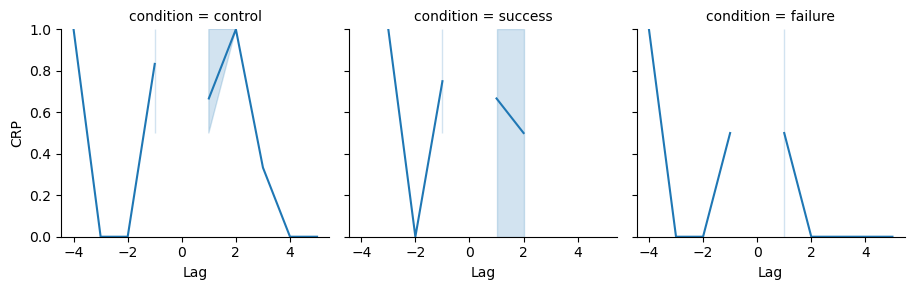

In [14]:
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [15]:
ranks_control = fr.lag_rank(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks_success = fr.lag_rank(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks_attempt = fr.lag_rank(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks = pd.concat([ranks_control.assign(condition='control'), ranks_success.assign(condition='success'), ranks_attempt.assign(condition='failure')])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.537037
sem     0.291041
Name: rank, dtype: float64
success
mean    0.375
sem       NaN
Name: rank, dtype: float64
failure
mean    0.6875
sem     0.3125
Name: rank, dtype: float64


/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.375
1,1,NaN
2,2,NaN


## Focusing on Transitions from Mid-Sequence Items

,subject,lag,prob,actual,possible,condition
0,0,-5,0.250000,1,4,control
1,0,-4,0.400000,2,5,control
2,0,-3,0.000000,0,7,control
3,0,-2,0.142857,1,7,control
4,0,-1,0.500000,4,8,control
...,...,...,...,...,...,...
17,1,1,1.000000,2,2,failure
18,1,2,0.000000,0,1,failure
19,1,3,NaN,0,0,failure
20,1,4,NaN,0,0,failure


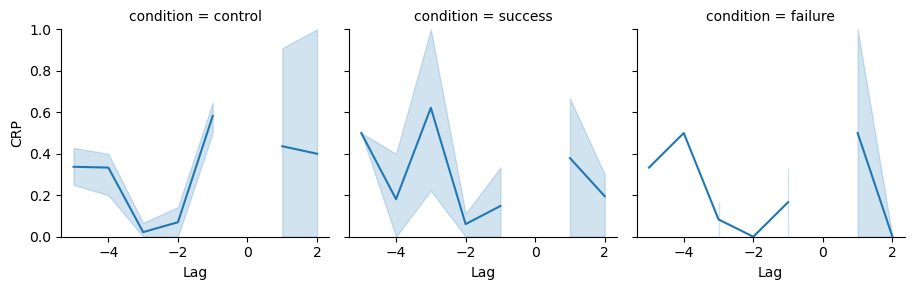

In [16]:
# %% From Mid-List Transition Lag-CRP
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])
# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [17]:
# %% From-Mid-List Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
ranks_success = fr.lag_rank(data.query('condition == 2'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)
ranks_attempt = fr.lag_rank(data.query('condition == 1'), 
    test_key='input', test=lambda x, y: 4 <= x <= 9
)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.646382
sem     0.053297
Name: rank, dtype: float64
success
mean    0.396825
sem     0.136444
Name: rank, dtype: float64
failure
mean    0.625
sem     0.250
Name: rank, dtype: float64


,subject,rank
0,0,0.125000
1,1,0.553571
2,2,0.511905


In [18]:
# %% Comparison: From-Early-Or-Late-List Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), 
    test_key='input', test=lambda x, y: (x < 4) or (x > 9)
)
ranks_success = fr.lag_rank(data.query('condition == 2'), 
    test_key='input', test=lambda x, y: (x < 4) or (x > 9)
)
ranks_attempt = fr.lag_rank(data.query('condition == 1'), 
    test_key='input', test=lambda x, y: (x < 4) or (x > 9)
)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.770079
sem     0.096358
Name: rank, dtype: float64
success
mean    0.695246
sem     0.110021
Name: rank, dtype: float64
failure
mean    0.700000
sem     0.041667
Name: rank, dtype: float64


,subject,rank
0,0,0.493056
1,1,0.871528
2,2,0.721154
